<h1 style="text-align:center;"><b>Laboratorio 2</b></h1>
<h3 style="text-align:center;">Alina Carías (22539), Daniel Machic (22118), Ariela Mishaan (22052)</h3>

**Github**: https://github.com/ArielaMishaanCohen/LAB2.git  

# Librerías

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from imageio.v3 import imread
import cv2


## Task 1

**Cargar imagen en escala de grises (1)**

In [ ]:
img = imread("periodic_noise.jpg")

if img.ndim == 3:
    img = (0.299*img[...,0] + 0.587*img[...,1] + 0.114*img[...,2])

img = img.astype(np.float32)

plt.figure(figsize=(6,6))
plt.imshow(img, cmap="gray")
plt.title("Imagen original (con ruido periódico)")
plt.axis("off")
plt.show()


**DFT y Espectro de magnitud (2,3)**

In [ ]:
F = np.fft.fft2(img)
Fshift = np.fft.fftshift(F)

magnitude = np.abs(Fshift)
log_spectrum = np.log1p(magnitude)

plt.figure(figsize=(6,6))
plt.imshow(log_spectrum, cmap="gray")
plt.title("Espectro de magnitud (log)")
plt.axis("off")
plt.show()


**Indentificación de picos del ruido (4)**

In [ ]:
h, w = log_spectrum.shape
cy, cx = h//2, w//2

# Eliminar el DC
dc_r = 6
Y, X = np.ogrid[:h, :w]
dc_mask = (Y-cy)**2 + (X-cx)**2 <= dc_r**2

spec = log_spectrum.copy()
spec[dc_mask] = 0

# Tomar una cantidad k de picos altos
K = 12
flat = spec.ravel()
idx = np.argpartition(flat, -K)[-K:]
idx = idx[np.argsort(flat[idx])[::-1]]
cands = [np.unravel_index(i, spec.shape) for i in idx]

# Eliminar picos cercanos
min_dist = 12
peaks = []
for (py, px) in cands:
    ok = True
    for (qy, qx) in peaks:
        if (py-qy)**2 + (px-qx)**2 < min_dist**2:
            ok = False
            break
    if ok:
        peaks.append((py, px))

print("Picos detectados:", peaks)

plt.figure(figsize=(7,7))
plt.imshow(log_spectrum, cmap="gray")
plt.title("Picos del ruido (rojo) + simétricos (cyan)")
for (py, px) in peaks:
    plt.scatter([px],[py], s=80, facecolors="none", edgecolors="r", linewidths=2)
    sy, sx = 2*cy - py, 2*cx - px
    plt.scatter([sx],[sy], s=80, facecolors="none", edgecolors="cyan", linewidths=2)
plt.axis("off")
plt.show()


**Máscara notch (5)**

In [ ]:
mask = np.ones((h, w), dtype=np.float32)

notch_r = 11  # Manejo de las lineas horizonatales

def zero_circle(y0, x0, r):
    circle = (Y-y0)**2 + (X-x0)**2 <= r**2
    mask[circle] = 0

for (py, px) in peaks:
    zero_circle(py, px, notch_r)
    sy, sx = 2*cy - py, 2*cx - px
    zero_circle(sy, sx, notch_r)

mask[dc_mask] = 1

F_filt = Fshift * mask
img_back = np.real(np.fft.ifft2(np.fft.ifftshift(F_filt)))

plt.figure(figsize=(14,5))

plt.subplot(1,3,1)
plt.imshow(img, cmap="gray")
plt.title("Original")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(np.log1p(np.abs(F_filt)), cmap="gray")
plt.title("Espectro filtrado (log)")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(img_back, cmap="gray")
plt.title("Restaurada (Notch + IDFT)")
plt.axis("off")

plt.show()


**Restaurar imagen (6)** 

In [ ]:
diff = np.abs(img_back)

plt.figure(figsize=(6,6))
plt.imshow(diff, cmap="gray")
plt.title("Diferencia |original - restaurada|")
plt.axis("off")
plt.show()


**Explicación**

Un filtro promedio en el dominio espacial suaviza toda la imagen por igual. Eso reduce las rayas, pero también borra bordes y texturas reales, porque elimina altas frecuencias útiles junto con el ruido. Sin embargo, el ruido periódico se muestra como picos específicos con Fourier. Un notch filter deja anular únicamente frecuencias extrañas y converva el resto de la información, manteniendo detalles nítidos. 

In [ ]:
# Fuentes: 
# https://www.geeksforgeeks.org/computer-vision/fast-fourier-transform-in-image-processing/ 
# https://stackoverflow.com/questions/65483030/notch-reject-filtering-in-python

# Task 2

**Cargar imagen binaria (1)**

In [ ]:
img_gris = cv2.imread('fingerprint_noisy.png', 0) # 0 = escala de grises

# Binarizar (Umbral) -> arriba del 127 se convierte a negro. 
_, img_binaria = cv2.threshold(img_gris, 127, 255, cv2.THRESH_BINARY)

plt.imshow(img_binaria, cmap='gray') 
plt.axis('off')
plt.show()


**Operación morfológica para eliminar ruido (2)**

Se escogió aplicar **apertura** a la imagen, ya que: 
- Erosión elimina ruido blanco pero rompe las crestas. 
- Dilatación agranda el ruido blanco
- Cierre (dilatación -> erosión) sirve para cerrar huecos negros, no elimina puntos blancos. 
- La apertura (erosión -> dilatación) elimina objetos blancos pequeños y conserva estructuras grandes (crestas). 

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
apertura = cv2.morphologyEx(img_binaria, cv2.MORPH_OPEN, kernel)

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(121), plt.imshow(img_binaria, cmap='gray'), plt.title("Original")
plt.subplot(122), plt.imshow(apertura, cmap='gray'), plt.title("Después de Apertura")
plt.show()


**Segunda operación para conectar grietas en las crestas de la huella (3)**

Después de aplicar la apertura, se ve que la imagen ya tiene menos ruido blanco, pero las crestas siguen teniendo pequeñas grietas. Por ello después se aplica el cierre, con el objetivo de cerrar uecos negros pequeños y conectar estructuras blancas cercanas.

In [ ]:
kernel_cierre = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
cierre = cv2.morphologyEx(apertura, cv2.MORPH_CLOSE, kernel_cierre)

**Mostrar imágenes (4)**

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(131)
plt.imshow(img_binaria, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(132)
plt.imshow(apertura, cmap='gray')
plt.title("Después de Apertura")
plt.axis('off')

plt.subplot(133)
plt.imshow(cierre, cmap='gray')
plt.title("Apertura + Cierre (Final)")
plt.axis('off')

plt.show()


**¿El orden de los factores altera el producto?**

Si se hubieran aplicado las operaciones en orden inverso, es decir, si el cierre se aplicara antes de la apertura, el ruido blanco sería dilatado, aumentando su tamaño y dificultando su eliminación posterior. Por ello, el orden de apertura seguido de cierre es fundamentarl ara eliminar el fuido sin comprometer la continuidad de las crestas. A continuación se puede ver qué hubiera sucedido en el caso de aplicar las operaciones al revés.

In [ ]:
img_gris = cv2.imread('fingerprint_noisy.png', 0) # 0 = escala de grises

# Binarizar (Umbral) -> arriba del 127 se convierte a negro. 
_, img_binaria = cv2.threshold(img_gris, 127, 255, cv2.THRESH_BINARY)

kernel_cierre = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
cierre = cv2.morphologyEx(img_binaria, cv2.MORPH_CLOSE, kernel_cierre)

kernel_apertura = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
apertura = cv2.morphologyEx(cierre, cv2.MORPH_OPEN, kernel_apertura)

plt.figure(figsize=(12,4))

plt.subplot(131)
plt.imshow(img_binaria, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(132)
plt.imshow(cierre, cmap='gray')
plt.title("Después de Cierre")
plt.axis('off')

plt.subplot(133)
plt.imshow(cierre, cmap='gray')
plt.title("Cierre + Apertura (Final)")
plt.axis('off')

plt.show()


Se puede ver que en el caso de aplicar cierre seguido de apertura, las líneas negras muestran discontinuidades y el ruido blanco no fue eliminado. 

# Task 3

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

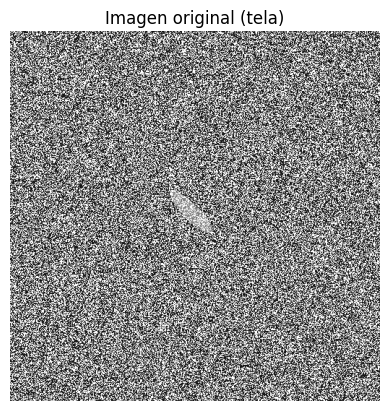

In [22]:
img = cv2.imread("textile_defect.jpg", cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap='gray')
plt.title("Imagen original (tela)")
plt.axis("off")

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

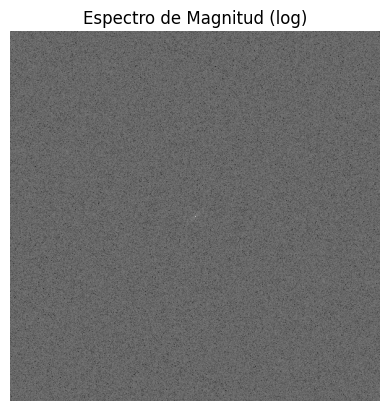

In [23]:
# FFT y espectro de magnitud
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)

magnitude = np.log(1 + np.abs(fshift))

plt.imshow(magnitude, cmap='gray')
plt.title("Espectro de Magnitud (log)")
plt.axis("off")

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

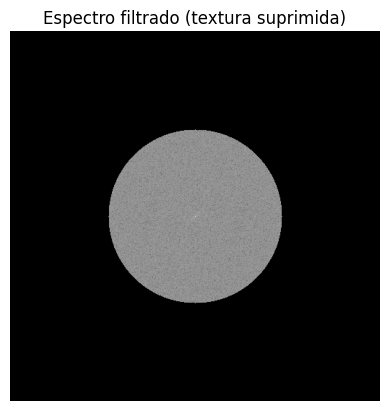

In [24]:
#  Filtro en frecuencia (supresión de textura)
rows, cols = img.shape
crow, ccol = rows // 2, cols // 2

mask = np.zeros((rows, cols), np.uint8)
radius = 120  # AJUSTABLE
cv2.circle(mask, (ccol, crow), radius, 1, -1)

fshift_filt = fshift * mask

plt.imshow(np.log(1 + np.abs(fshift_filt)), cmap='gray')
plt.title("Espectro filtrado (textura suprimida)")
plt.axis("off")

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

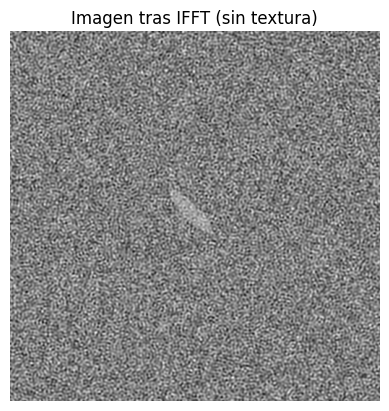

In [25]:
#  IFFT (volver al dominio espacial)
f_ishift = np.fft.ifftshift(fshift_filt)
img_suavizada = np.fft.ifft2(f_ishift)
img_suavizada = np.abs(img_suavizada)

plt.imshow(img_suavizada, cmap='gray')
plt.title("Imagen tras IFFT (sin textura)")
plt.axis("off")

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

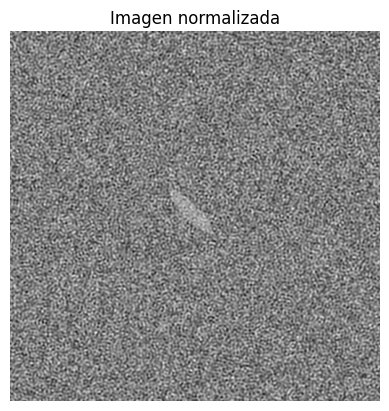

In [26]:
#Normalización
img_norm = cv2.normalize(
    img_suavizada, None,
    alpha=0, beta=255,
    norm_type=cv2.NORM_MINMAX
).astype(np.uint8)

plt.imshow(img_norm, cmap='gray')
plt.title("Imagen normalizada")
plt.axis("off")

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

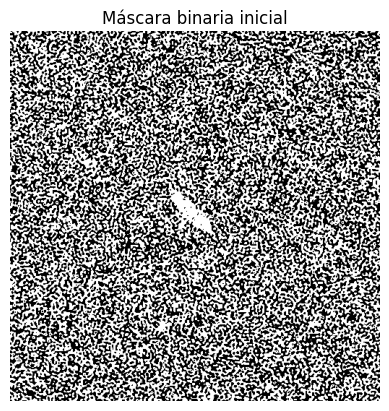

In [27]:
# Thresholding (segmentación)
_, mask_bin = cv2.threshold(
    img_suavizada.astype(np.uint8),
    0, 255,
    cv2.THRESH_BINARY + cv2.THRESH_OTSU
)

plt.imshow(mask_bin, cmap='gray')
plt.title("Máscara binaria inicial")
plt.axis("off")

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

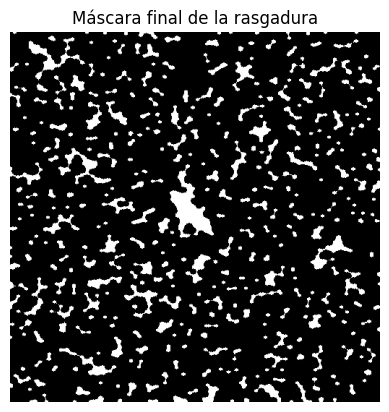

In [28]:
# Morfología (refinamiento)
kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
clean = cv2.morphologyEx(mask_bin, cv2.MORPH_OPEN, kernel_open)

kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))
final = cv2.morphologyEx(clean, cv2.MORPH_CLOSE, kernel_close)

plt.imshow(final, cmap='gray')
plt.title("Máscara final de la rasgadura")
plt.axis("off")

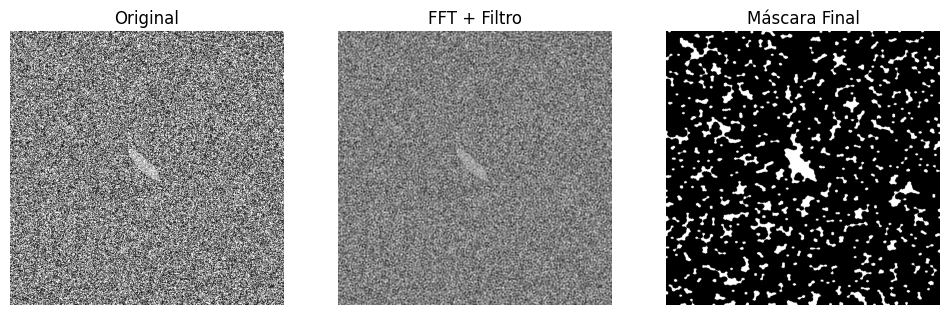

In [29]:
# Comparación final
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.title("Original")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(img_suavizada, cmap='gray')
plt.title("FFT + Filtro")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(final, cmap='gray')
plt.title("Máscara Final")
plt.axis("off")

plt.show()

La solución propuesta combina filtrado en el dominio de Fourier y operaciones morfológicas para aislar rasgaduras en telas con textura intensa. El filtrado de baja frecuencia permite atenuar parcialmente la textura del tejido, resaltando la rasgadura como una anomalía estructural; sin embargo, su efectividad depende fuertemente del radio seleccionado. Un radio mayor preserva mejor la rasgadura, pero introduce textura residual, evidenciando un trade-off entre supresión de textura y conservación de detalles. Además, la segmentación y la morfología priorizan robustez sobre precisión, pudiendo perder detalles finos. Por ello, la solución resulta específica para este tipo de imagen y textura, y no es completamente robusta ante variaciones en el tipo de tela o rasgaduras muy pequeñas. 